In [2]:
import pandas as pd
import os
from itables import show
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler

In [3]:
#finding out how many cpu cores you have
!wmic cpu get NumberOfCores,NumberOfLogicalProcessors

#divide the work between the existing cores - 1
os.environ['OMP_NUM_THREADS']='7'

NumberOfCores  NumberOfLogicalProcessors  

4              8                          





# Prepare data set for prediction

In [4]:
traffic = pd.read_csv('traffic_2020-2022.csv')
weather = pd.read_csv('weather_data_hourly.csv')
emissions = pd.read_csv('emission_huegelstr_hourly.csv')

In [5]:
weather

,timestamp,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad]
0,2018-01-01 00:00:00,1002.5,75.75,8.85,2.50,242.5
1,2018-01-01 01:00:00,1004.0,63.35,10.85,2.35,236.5
2,2018-01-01 02:00:00,1004.5,65.25,10.30,2.35,239.0
3,2018-01-01 03:00:00,1005.0,63.05,10.05,2.30,240.0
4,2018-01-01 04:00:00,1006.0,60.95,9.55,2.45,241.0
...,...,...,...,...,...,...
50070,2023-09-18 06:00:00,1006.0,93.90,18.15,0.90,170.5
50071,2023-09-18 07:00:00,1006.5,88.10,18.50,0.90,186.5
50072,2023-09-18 08:00:00,1007.0,83.40,19.15,0.85,161.5
50073,2023-09-18 09:00:00,1007.0,78.10,20.10,1.20,174.5


In [6]:
emissions

,timestamp,Benzol,CO,m-/p-Xylol,o-Xylol,"PM2,5",PM10,NO2,NO,Toluol
0,2018-01-01 00:00:00,0.82,0.25,0.22,0.22,NaN,169.50,21.65,19.80,0.46
1,2018-01-01 01:00:00,1.32,0.19,0.22,0.22,NaN,88.70,15.40,6.60,0.52
2,2018-01-01 02:00:00,0.35,0.16,0.22,0.22,NaN,23.80,13.55,5.95,0.19
3,2018-01-01 03:00:00,0.37,0.17,0.22,0.22,NaN,23.75,12.25,5.70,0.31
4,2018-01-01 04:00:00,0.34,0.17,0.22,0.22,NaN,16.20,11.85,5.00,0.19
...,...,...,...,...,...,...,...,...,...,...
50070,2023-09-18 06:00:00,0.18,NaN,0.54,0.22,9.00,20.55,11.50,2.95,0.90
50071,2023-09-18 07:00:00,0.21,NaN,0.63,0.22,9.25,20.80,17.35,7.75,0.88
50072,2023-09-18 08:00:00,0.29,NaN,1.47,0.63,8.20,18.70,20.55,10.15,1.96
50073,2023-09-18 09:00:00,0.24,NaN,0.76,0.36,7.80,18.60,19.00,8.85,1.86


In [7]:
traffic

,timestamp,inbound,outbound
0,2020-06-01 00:00:00,965.0,7038.0
1,2020-06-01 01:00:00,486.0,3824.0
2,2020-06-01 02:00:00,283.0,2062.0
3,2020-06-01 03:00:00,164.0,1660.0
4,2020-06-01 04:00:00,159.0,1836.0
...,...,...,...
17536,2022-06-01 20:00:00,2739.0,20770.0
17537,2022-06-01 21:00:00,2248.0,15870.0
17538,2022-06-01 22:00:00,1703.0,12972.0
17539,2022-06-01 23:00:00,968.0,7456.0


In [8]:
pred_data = traffic.merge(weather, how='left', on= 'timestamp').merge(emissions[['PM10','PM2,5', 'NO2','timestamp']], how='left', on= 'timestamp')
show(pred_data)

df = pred_data.copy()

In [11]:
df.index = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df[:26]

,timestamp,inbound,outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],PM10,"PM2,5",NO2
timestamp,,,,,,,,,,,
2020-06-01 00:00:00,2020-06-01 00:00:00,965.0,7038.0,1021.0,72.75,13.10,0.60,96.0,9.25,4.75,9.70
2020-06-01 01:00:00,2020-06-01 01:00:00,486.0,3824.0,1022.0,81.75,10.75,0.40,112.0,5.65,3.25,10.05
2020-06-01 02:00:00,2020-06-01 02:00:00,283.0,2062.0,1022.0,93.05,9.35,0.45,76.5,5.05,3.05,11.40
2020-06-01 03:00:00,2020-06-01 03:00:00,164.0,1660.0,1022.0,96.55,8.40,0.55,71.5,6.25,3.35,11.10
2020-06-01 04:00:00,2020-06-01 04:00:00,159.0,1836.0,1022.0,98.55,7.80,0.40,111.5,6.00,3.35,9.65
2020-06-01 05:00:00,2020-06-01 05:00:00,506.0,4498.0,1022.0,97.25,8.15,0.50,110.0,6.50,3.85,13.00
2020-06-01 06:00:00,2020-06-01 06:00:00,560.0,5340.0,1022.0,86.20,10.90,1.05,52.0,6.10,3.65,8.80
2020-06-01 07:00:00,2020-06-01 07:00:00,636.0,5756.0,1022.0,71.90,13.45,1.40,41.5,6.30,3.25,6.30
2020-06-01 08:00:00,2020-06-01 08:00:00,922.0,7080.0,1022.0,62.55,15.80,1.60,48.5,8.75,3.60,5.45


# Univariate Time Series Forecasting (LSTM)

<Axes: xlabel='timestamp'>

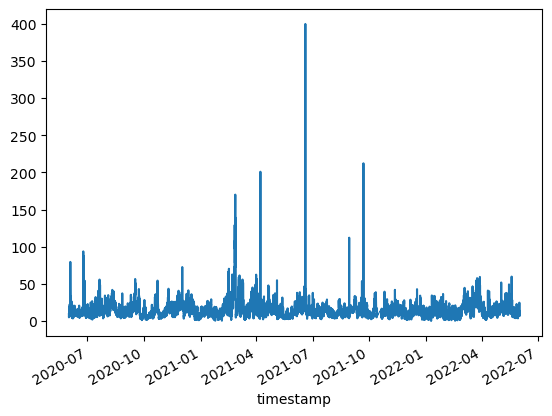

In [12]:
emissions = df['PM10']
emissions.plot()

In [13]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [14]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(emissions, WINDOW_SIZE)
X1.shape, y1.shape

((5827, 5, 1), (5827,))

In [15]:
X_train1, y_train1 = X1[:4000], y1[:4000]
X_val1, y_val1 = X1[4000:4800], y1[4000:4800]
X_test1, y_test1 = X1[4800:], y1[4800:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((4000, 5, 1), (4000,), (800, 5, 1), (800,), (1027, 5, 1), (1027,))

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [19]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [20]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
121/125 [============================>.] - ETA: 0s - loss: 256.1839 - root_mean_squared_error: 16.0057

125/125 [==============================] - 22s 141ms/step - loss: 254.6886 - root_mean_squared_error: 15.9590 - val_loss: 238.3633 - val_root_mean_squared_error: 15.4390
Epoch 2/10
116/125 [==========================>...] - ETA: 0s - loss: 196.2001 - root_mean_squared_error: 14.0071

125/125 [==============================] - 13s 105ms/step - loss: 193.2422 - root_mean_squared_error: 13.9012 - val_loss: 172.1383 - val_root_mean_squared_error: 13.1201
Epoch 3/10
116/125 [==========================>...] - ETA: 0s - loss: 135.1630 - root_mean_squared_error: 11.6260

125/125 [==============================] - 15s 124ms/step - loss: 134.1337 - root_mean_squared_error: 11.5816 - val_loss: 122.2984 - val_root_mean_squared_error: 11.0589
Epoch 4/10
124/125 [============================>.] - ETA: 0s - loss: 100.8133 - root_mean_squared_error: 10.0406

125/125 [==============================] - 18s 143ms/step - loss: 100.7765 - root_mean_squared_error: 10.0388 - val_loss: 99.8970 - val_root_mean_squared_error: 9.9948
Epoch 5/10
124/125 [============================>.] - ETA: 0s - loss: 86.5703 - root_mean_squared_error: 9.3043

125/125 [==============================] - 16s 126ms/step - loss: 86.8760 - root_mean_squared_error: 9.3207 - val_loss: 89.6850 - val_root_mean_squared_error: 9.4702
Epoch 6/10
124/125 [============================>.] - ETA: 0s - loss: 79.9897 - root_mean_squared_error: 8.9437

125/125 [==============================] - 20s 163ms/step - loss: 79.5814 - root_mean_squared_error: 8.9208 - val_loss: 82.6067 - val_root_mean_squared_error: 9.0888
Epoch 7/10
119/125 [===========================>..] - ETA: 0s - loss: 74.5821 - root_mean_squared_error: 8.6361

125/125 [==============================] - 17s 133ms/step - loss: 73.6681 - root_mean_squared_error: 8.5830 - val_loss: 75.9647 - val_root_mean_squared_error: 8.7158
Epoch 8/10
122/125 [============================>.] - ETA: 0s - loss: 68.3043 - root_mean_squared_error: 8.2646

125/125 [==============================] - 17s 138ms/step - loss: 67.8886 - root_mean_squared_error: 8.2395 - val_loss: 70.3923 - val_root_mean_squared_error: 8.3900
Epoch 9/10
122/125 [============================>.] - ETA: 0s - loss: 62.4827 - root_mean_squared_error: 7.9046

125/125 [==============================] - 17s 140ms/step - loss: 62.7549 - root_mean_squared_error: 7.9218 - val_loss: 64.8969 - val_root_mean_squared_error: 8.0559
Epoch 10/10
118/125 [===========================>..] - ETA: 0s - loss: 59.1280 - root_mean_squared_error: 7.6895

125/125 [==============================] - 22s 176ms/step - loss: 58.7959 - root_mean_squared_error: 7.6678 - val_loss: 61.1792 - val_root_mean_squared_error: 7.8217


In [21]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [22]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

125/125 [==============================] - 2s 6ms/step


,Train Predictions,Actuals
0,13.622010,11.6
1,12.852242,11.3
2,12.448582,14.6
3,14.167357,19.6
4,16.603041,23.2
...,...,...
3995,16.614370,17.7
3996,16.728550,17.9
3997,16.839226,17.8
3998,16.841763,13.4


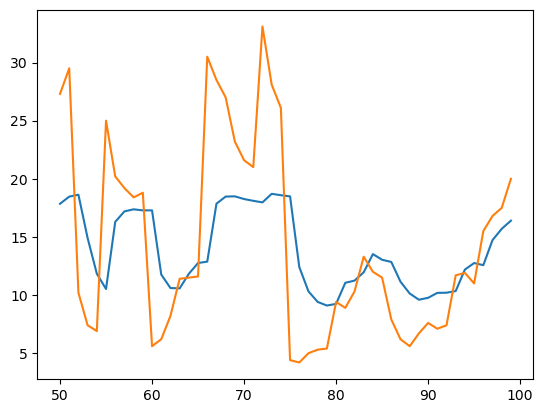

In [23]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [24]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

25/25 [==============================] - 0s 8ms/step


,Val Predictions,Actuals
0,14.263607,19.2
1,16.511623,17.4
2,16.495144,17.5
3,16.678539,29.1
4,18.428648,30.4
...,...,...
795,16.460543,16.3
796,16.187681,10.4
797,13.122576,9.6
798,12.028946,10.5


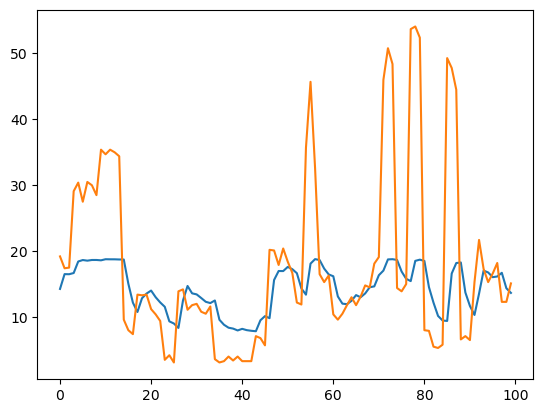

In [25]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [26]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

33/33 [==============================] - 1s 4ms/step


,Test Predictions,Actuals
0,12.458536,13.0
1,13.327362,11.8
2,12.998719,13.1
3,13.579942,14.8
4,14.517666,14.5
...,...,...
1022,11.349430,10.9
1023,11.990904,10.8
1024,12.349892,7.7
1025,11.161692,7.6


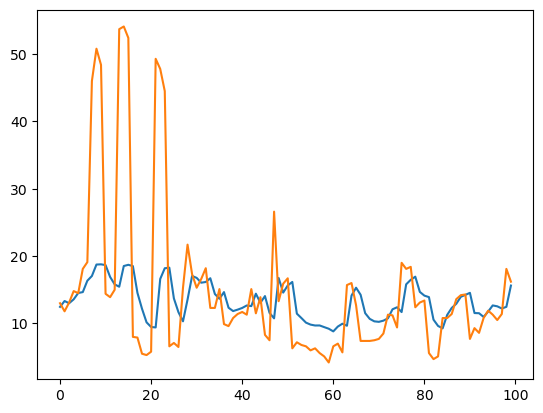

In [27]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

## Convolutional Neural Network

In [28]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [29]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [30]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
117/125 [===========================>..] - ETA: 0s - loss: 189.3554 - root_mean_squared_error: 13.7606

125/125 [==============================] - 5s 34ms/step - loss: 183.3951 - root_mean_squared_error: 13.5423 - val_loss: 91.6827 - val_root_mean_squared_error: 9.5751
Epoch 2/10
121/125 [============================>.] - ETA: 0s - loss: 75.1201 - root_mean_squared_error: 8.6672

125/125 [==============================] - 2s 17ms/step - loss: 74.9463 - root_mean_squared_error: 8.6572 - val_loss: 68.0379 - val_root_mean_squared_error: 8.2485
Epoch 3/10
118/125 [===========================>..] - ETA: 0s - loss: 59.0765 - root_mean_squared_error: 7.6861

125/125 [==============================] - 3s 24ms/step - loss: 59.4301 - root_mean_squared_error: 7.7091 - val_loss: 56.2023 - val_root_mean_squared_error: 7.4968
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 50.3884 - root_mean_squared_error: 7.0985

125/125 [==============================] - 3s 21ms/step - loss: 50.3884 - root_mean_squared_error: 7.0985 - val_loss: 49.1613 - val_root_mean_squared_error: 7.0115
Epoch 5/10
125/125 [==============================] - ETA: 0s - loss: 44.9420 - root_mean_squared_error: 6.7039

125/125 [==============================] - 3s 26ms/step - loss: 44.9420 - root_mean_squared_error: 6.7039 - val_loss: 45.0698 - val_root_mean_squared_error: 6.7134
Epoch 6/10
107/125 [========================>.....] - ETA: 0s - loss: 41.5436 - root_mean_squared_error: 6.4454

125/125 [==============================] - 3s 24ms/step - loss: 41.7826 - root_mean_squared_error: 6.4639 - val_loss: 43.0783 - val_root_mean_squared_error: 6.5634
Epoch 7/10
124/125 [============================>.] - ETA: 0s - loss: 40.0119 - root_mean_squared_error: 6.3255

125/125 [==============================] - 3s 24ms/step - loss: 40.0868 - root_mean_squared_error: 6.3314 - val_loss: 41.3868 - val_root_mean_squared_error: 6.4333
Epoch 8/10
111/125 [=========================>....] - ETA: 0s - loss: 37.5211 - root_mean_squared_error: 6.1254

125/125 [==============================] - 3s 20ms/step - loss: 39.0336 - root_mean_squared_error: 6.2477 - val_loss: 40.5175 - val_root_mean_squared_error: 6.3653
Epoch 9/10
114/125 [==========================>...] - ETA: 0s - loss: 39.0350 - root_mean_squared_error: 6.2478

125/125 [==============================] - 3s 26ms/step - loss: 38.3272 - root_mean_squared_error: 6.1909 - val_loss: 39.9356 - val_root_mean_squared_error: 6.3195
Epoch 10/10
122/125 [============================>.] - ETA: 0s - loss: 38.2703 - root_mean_squared_error: 6.1863

125/125 [==============================] - 3s 21ms/step - loss: 37.9420 - root_mean_squared_error: 6.1597 - val_loss: 39.5050 - val_root_mean_squared_error: 6.2853


## GRU (Gated Recurrent Unit)

In [31]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [32]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [33]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3])

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 281.2291 - root_mean_squared_error: 16.7699

125/125 [==============================] - 18s 118ms/step - loss: 281.2291 - root_mean_squared_error: 16.7699 - val_loss: 264.4203 - val_root_mean_squared_error: 16.2610
Epoch 2/10
122/125 [============================>.] - ETA: 0s - loss: 227.0378 - root_mean_squared_error: 15.0678

125/125 [==============================] - 12s 100ms/step - loss: 226.7217 - root_mean_squared_error: 15.0573 - val_loss: 214.4881 - val_root_mean_squared_error: 14.6454
Epoch 3/10
113/125 [==========================>...] - ETA: 0s - loss: 163.7390 - root_mean_squared_error: 12.7961

125/125 [==============================] - 11s 91ms/step - loss: 160.4006 - root_mean_squared_error: 12.6649 - val_loss: 140.1203 - val_root_mean_squared_error: 11.8372
Epoch 4/10
119/125 [===========================>..] - ETA: 0s - loss: 113.9864 - root_mean_squared_error: 10.6764

125/125 [==============================] - 11s 91ms/step - loss: 112.5770 - root_mean_squared_error: 10.6102 - val_loss: 108.2469 - val_root_mean_squared_error: 10.4042
Epoch 5/10
123/125 [============================>.] - ETA: 0s - loss: 90.7656 - root_mean_squared_error: 9.5271

125/125 [==============================] - 11s 92ms/step - loss: 90.7137 - root_mean_squared_error: 9.5244 - val_loss: 90.7175 - val_root_mean_squared_error: 9.5246
Epoch 6/10
117/125 [===========================>..] - ETA: 0s - loss: 78.6619 - root_mean_squared_error: 8.8692

125/125 [==============================] - 12s 95ms/step - loss: 77.6429 - root_mean_squared_error: 8.8115 - val_loss: 78.6238 - val_root_mean_squared_error: 8.8670
Epoch 7/10
123/125 [============================>.] - ETA: 0s - loss: 68.1311 - root_mean_squared_error: 8.2542

125/125 [==============================] - 13s 102ms/step - loss: 68.6744 - root_mean_squared_error: 8.2870 - val_loss: 70.5856 - val_root_mean_squared_error: 8.4015
Epoch 8/10
125/125 [==============================] - ETA: 0s - loss: 62.6466 - root_mean_squared_error: 7.9150

125/125 [==============================] - 13s 102ms/step - loss: 62.6466 - root_mean_squared_error: 7.9150 - val_loss: 65.0731 - val_root_mean_squared_error: 8.0668
Epoch 9/10
122/125 [============================>.] - ETA: 0s - loss: 58.8106 - root_mean_squared_error: 7.6688

125/125 [==============================] - 12s 96ms/step - loss: 58.4406 - root_mean_squared_error: 7.6446 - val_loss: 60.7980 - val_root_mean_squared_error: 7.7973
Epoch 10/10
111/125 [=========================>....] - ETA: 0s - loss: 54.2419 - root_mean_squared_error: 7.3649

125/125 [==============================] - 12s 95ms/step - loss: 54.9930 - root_mean_squared_error: 7.4157 - val_loss: 57.2446 - val_root_mean_squared_error: 7.5660


# Multivariate Time Series Forecasting (LSTM) for one target

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

## Preprocessing

In [15]:
multi_df

,timestamp,inbound,outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],PM10,"PM2,5",NO2
0,2020-06-01 00:00:00,965.0,7038.0,1021.0,72.75,13.10,0.60,96.0,9.25,4.75,9.70
1,2020-06-01 01:00:00,486.0,3824.0,1022.0,81.75,10.75,0.40,112.0,5.65,3.25,10.05
2,2020-06-01 02:00:00,283.0,2062.0,1022.0,93.05,9.35,0.45,76.5,5.05,3.05,11.40
3,2020-06-01 03:00:00,164.0,1660.0,1022.0,96.55,8.40,0.55,71.5,6.25,3.35,11.10
4,2020-06-01 04:00:00,159.0,1836.0,1022.0,98.55,7.80,0.40,111.5,6.00,3.35,9.65
...,...,...,...,...,...,...,...,...,...,...,...
17536,2022-06-01 20:00:00,2739.0,20770.0,1014.0,41.10,17.95,2.15,326.0,6.90,3.20,15.80
17537,2022-06-01 21:00:00,2248.0,15870.0,1015.5,48.25,15.70,1.30,335.0,7.85,3.60,25.30
17538,2022-06-01 22:00:00,1703.0,12972.0,1016.0,59.55,13.30,0.75,198.0,8.35,4.00,32.30
17539,2022-06-01 23:00:00,968.0,7456.0,1017.0,78.35,11.10,0.70,41.0,9.65,4.70,26.60


In [17]:
multi_df = pred_data.copy()
multi_df.index = pd.to_datetime(multi_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
multi_df['Seconds'] = multi_df.index.map(pd.Timestamp.timestamp)
multi_df

,timestamp,inbound,outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],PM10,"PM2,5",NO2,Seconds
timestamp,,,,,,,,,,,,
2020-06-01 00:00:00,2020-06-01 00:00:00,965.0,7038.0,1021.0,72.75,13.10,0.60,96.0,9.25,4.75,9.70,1.590970e+09
2020-06-01 01:00:00,2020-06-01 01:00:00,486.0,3824.0,1022.0,81.75,10.75,0.40,112.0,5.65,3.25,10.05,1.590973e+09
2020-06-01 02:00:00,2020-06-01 02:00:00,283.0,2062.0,1022.0,93.05,9.35,0.45,76.5,5.05,3.05,11.40,1.590977e+09
2020-06-01 03:00:00,2020-06-01 03:00:00,164.0,1660.0,1022.0,96.55,8.40,0.55,71.5,6.25,3.35,11.10,1.590980e+09
2020-06-01 04:00:00,2020-06-01 04:00:00,159.0,1836.0,1022.0,98.55,7.80,0.40,111.5,6.00,3.35,9.65,1.590984e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 20:00:00,2022-06-01 20:00:00,2739.0,20770.0,1014.0,41.10,17.95,2.15,326.0,6.90,3.20,15.80,1.654114e+09
2022-06-01 21:00:00,2022-06-01 21:00:00,2248.0,15870.0,1015.5,48.25,15.70,1.30,335.0,7.85,3.60,25.30,1.654117e+09
2022-06-01 22:00:00,2022-06-01 22:00:00,1703.0,12972.0,1016.0,59.55,13.30,0.75,198.0,8.35,4.00,32.30,1.654121e+09


In [18]:
day = 60*60*24
year = 365.2425*day

multi_df['Day sin'] = np.sin(multi_df['Seconds'] * (2* np.pi / day))
multi_df['Day cos'] = np.cos(multi_df['Seconds'] * (2 * np.pi / day))
multi_df['Year sin'] = np.sin(multi_df['Seconds'] * (2 * np.pi / year))
multi_df['Year cos'] = np.cos(multi_df['Seconds'] * (2 * np.pi / year))
multi_df.head()


,timestamp,inbound,outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],PM10,"PM2,5",NO2,Seconds,Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,2020-06-01 00:00:00,965.0,7038.0,1021.0,72.75,13.10,0.60,96.0,9.25,4.75,9.70,1.590970e+09,-9.128657e-12,1.000000,0.504602,-0.863352
2020-06-01 01:00:00,2020-06-01 01:00:00,486.0,3824.0,1022.0,81.75,10.75,0.40,112.0,5.65,3.25,10.05,1.590973e+09,2.588190e-01,0.965926,0.503983,-0.863714
2020-06-01 02:00:00,2020-06-01 02:00:00,283.0,2062.0,1022.0,93.05,9.35,0.45,76.5,5.05,3.05,11.40,1.590977e+09,5.000000e-01,0.866025,0.503364,-0.864075
2020-06-01 03:00:00,2020-06-01 03:00:00,164.0,1660.0,1022.0,96.55,8.40,0.55,71.5,6.25,3.35,11.10,1.590980e+09,7.071068e-01,0.707107,0.502744,-0.864435
2020-06-01 04:00:00,2020-06-01 04:00:00,159.0,1836.0,1022.0,98.55,7.80,0.40,111.5,6.00,3.35,9.65,1.590984e+09,8.660254e-01,0.500000,0.502125,-0.864795


In [19]:
#move target to be first column
column_to_move = multi_df.pop('PM10')
multi_df.insert(0, 'PM10', column_to_move)
multi_df

,PM10,timestamp,inbound,outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],"PM2,5",NO2,Seconds,Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,9.25,2020-06-01 00:00:00,965.0,7038.0,1021.0,72.75,13.10,0.60,96.0,4.75,9.70,1.590970e+09,-9.128657e-12,1.000000,0.504602,-0.863352
2020-06-01 01:00:00,5.65,2020-06-01 01:00:00,486.0,3824.0,1022.0,81.75,10.75,0.40,112.0,3.25,10.05,1.590973e+09,2.588190e-01,0.965926,0.503983,-0.863714
2020-06-01 02:00:00,5.05,2020-06-01 02:00:00,283.0,2062.0,1022.0,93.05,9.35,0.45,76.5,3.05,11.40,1.590977e+09,5.000000e-01,0.866025,0.503364,-0.864075
2020-06-01 03:00:00,6.25,2020-06-01 03:00:00,164.0,1660.0,1022.0,96.55,8.40,0.55,71.5,3.35,11.10,1.590980e+09,7.071068e-01,0.707107,0.502744,-0.864435
2020-06-01 04:00:00,6.00,2020-06-01 04:00:00,159.0,1836.0,1022.0,98.55,7.80,0.40,111.5,3.35,9.65,1.590984e+09,8.660254e-01,0.500000,0.502125,-0.864795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 20:00:00,6.90,2022-06-01 20:00:00,2739.0,20770.0,1014.0,41.10,17.95,2.15,326.0,3.20,15.80,1.654114e+09,-8.660254e-01,0.500000,0.499419,-0.866360
2022-06-01 21:00:00,7.85,2022-06-01 21:00:00,2248.0,15870.0,1015.5,48.25,15.70,1.30,335.0,3.60,25.30,1.654117e+09,-7.071068e-01,0.707107,0.498798,-0.866718
2022-06-01 22:00:00,8.35,2022-06-01 22:00:00,1703.0,12972.0,1016.0,59.55,13.30,0.75,198.0,4.00,32.30,1.654121e+09,-5.000000e-01,0.866025,0.498177,-0.867075


In [21]:
#drop unwanted columns
multi_df = multi_df.drop(columns = ['timestamp', 'Seconds'])

In [22]:
#replace Nans with mean
multi_df = multi_df.fillna(multi_df.mean())

In [23]:
multi_df

,PM10,inbound,outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],"PM2,5",NO2,Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,,,,
2020-06-01 00:00:00,9.25,965.0,7038.0,1021.0,72.75,13.10,0.60,96.0,4.75,9.70,-9.128657e-12,1.000000,0.504602,-0.863352
2020-06-01 01:00:00,5.65,486.0,3824.0,1022.0,81.75,10.75,0.40,112.0,3.25,10.05,2.588190e-01,0.965926,0.503983,-0.863714
2020-06-01 02:00:00,5.05,283.0,2062.0,1022.0,93.05,9.35,0.45,76.5,3.05,11.40,5.000000e-01,0.866025,0.503364,-0.864075
2020-06-01 03:00:00,6.25,164.0,1660.0,1022.0,96.55,8.40,0.55,71.5,3.35,11.10,7.071068e-01,0.707107,0.502744,-0.864435
2020-06-01 04:00:00,6.00,159.0,1836.0,1022.0,98.55,7.80,0.40,111.5,3.35,9.65,8.660254e-01,0.500000,0.502125,-0.864795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 20:00:00,6.90,2739.0,20770.0,1014.0,41.10,17.95,2.15,326.0,3.20,15.80,-8.660254e-01,0.500000,0.499419,-0.866360
2022-06-01 21:00:00,7.85,2248.0,15870.0,1015.5,48.25,15.70,1.30,335.0,3.60,25.30,-7.071068e-01,0.707107,0.498798,-0.866718
2022-06-01 22:00:00,8.35,1703.0,12972.0,1016.0,59.55,13.30,0.75,198.0,4.00,32.30,-5.000000e-01,0.866025,0.498177,-0.867075


In [24]:
multi_df.describe()

,PM10,inbound,outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],"PM2,5",NO2,Day sin,Day cos,Year sin,Year cos
count,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,1.754100e+04,1.754100e+04,17541.000000,17541.000000
mean,14.228799,2913.552648,22921.042814,1017.280325,77.321671,11.009053,1.211699,149.424409,9.215885,27.321615,-2.749911e-05,-1.518672e-04,0.000366,-0.000728
std,10.375028,1952.465907,14514.316298,8.921590,20.474889,7.959869,0.611074,87.290741,6.079822,15.164261,7.071618e-01,7.070920e-01,0.706934,0.707320
min,0.500000,2.000000,0.000000,980.000000,24.250000,-10.700000,0.350000,1.000000,0.500000,2.150000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000
25%,8.250000,847.000000,9418.000000,1012.500000,61.900000,4.750000,0.750000,66.000000,4.700000,16.200000,-7.071068e-01,-7.071068e-01,-0.706555,-0.708442
50%,12.350000,3088.000000,24132.000000,1018.000000,83.050000,10.300000,1.100000,154.000000,7.700000,24.650000,-1.801471e-14,1.552518e-14,0.001240,-0.001566
75%,17.650000,4716.000000,34488.000000,1023.000000,95.600000,16.650000,1.550000,229.000000,12.200000,35.250000,7.071068e-01,7.071068e-01,0.706510,0.706786
max,399.500000,7056.000000,85356.000000,1041.000000,100.100000,37.300000,5.400000,360.000000,62.650000,156.950000,1.000000e+00,1.000000e+00,1.000000,1.000000


In [69]:
#standardize

scaler = MinMaxScaler(feature_range=(-1, 1))

multi_df_scaled = scaler.fit_transform(multi_df)
multi_df_scaled = pd.DataFrame(multi_df_scaled, columns=multi_df.columns, index=multi_df.index)


In [70]:
multi_df_scaled

,PM10,inbound,outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],"PM2,5",NO2,Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,,,,
2020-06-01 00:00:00,-0.956140,-0.726963,-0.835091,0.344262,0.278840,-8.333333e-03,-0.900990,-0.470752,-0.863234,-0.902455,-9.128657e-12,1.000000,0.504602,-0.863352
2020-06-01 01:00:00,-0.974185,-0.862773,-0.910399,0.377049,0.516150,-1.062500e-01,-0.980198,-0.381616,-0.911504,-0.897933,2.588190e-01,0.965926,0.503983,-0.863714
2020-06-01 02:00:00,-0.977193,-0.920329,-0.951685,0.377049,0.814107,-1.645833e-01,-0.960396,-0.579387,-0.917940,-0.880491,5.000000e-01,0.866025,0.503364,-0.864075
2020-06-01 03:00:00,-0.971178,-0.954069,-0.961104,0.377049,0.906394,-2.041667e-01,-0.920792,-0.607242,-0.908286,-0.884367,7.071068e-01,0.707107,0.502744,-0.864435
2020-06-01 04:00:00,-0.972431,-0.955486,-0.956980,0.377049,0.959130,-2.291667e-01,-0.980198,-0.384401,-0.908286,-0.903101,8.660254e-01,0.500000,0.502125,-0.864795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 20:00:00,-0.967920,-0.223986,-0.513332,0.114754,-0.555702,1.937500e-01,-0.287129,0.810585,-0.913113,-0.823643,-8.660254e-01,0.500000,0.499419,-0.866360
2022-06-01 21:00:00,-0.963158,-0.363198,-0.628146,0.163934,-0.367172,1.000000e-01,-0.623762,0.860724,-0.900241,-0.700904,-7.071068e-01,0.707107,0.498798,-0.866718
2022-06-01 22:00:00,-0.960652,-0.517720,-0.696049,0.180328,-0.069216,2.220446e-16,-0.841584,0.097493,-0.887369,-0.610465,-5.000000e-01,0.866025,0.498177,-0.867075


## Create tensors

In [71]:
#create X and Y
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    #define y
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [72]:
X2, y2 = df_to_X_y2(multi_df_scaled)
X2.shape, y2.shape

((17534, 7, 14), (17534,))

In [56]:
#split data
X2_train, y2_train = X2[:10000], y2[:10000]
X2_val, y2_val = X2[10000:13500], y2[10000:13500]
X2_test, y2_test = X2[13500:], y2[13500:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape


((10000, 7, 14), (10000,), (3500, 7, 14), (3500,), (4034, 7, 14), (4034,))

# Create model & predict

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model


from sklearn.metrics import mean_squared_error as mse

In [60]:
#create SMALL model

clear_session()

model4 = Sequential()
model4.add(InputLayer((7, 14)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20224     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 20,753
Trainable params: 20,753
Non-trainable params: 0
_________________________________________________________________


In [61]:
#set up checkpoint to save best model
cp4 = ModelCheckpoint('model4/', save_best_only=True)
#compile model 
model4.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [63]:
#create BIGGER model

# Clear the Keras session
clear_session()

# Set up checkpoint to save the best model
cp4 = ModelCheckpoint('model4/', save_best_only=True)

# Create the model
model4 = Sequential()

# Input layer
model4.add(InputLayer((7, 14)))

model4.add(LSTM(128, return_sequences=True))
model4.add(Dropout(0.2))

# Decrease the number of neurons in Dense layers and add L1-Regularization
model4.add(Dense(64, activation='relu', kernel_regularizer=l1(0.001)))
model4.add(Dense(16, activation='relu', kernel_regularizer=l1(0.001)))


model4.add(Dense(1, activation='linear'))

model4.compile(loss='mean_absolute_error', optimizer=Adagrad(learning_rate=1), metrics=[RootMeanSquaredError()])

# Display model summary
model4.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            73216     
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 dense (Dense)               (None, 7, 64)             8256      
                                                                 
 dense_1 (Dense)             (None, 7, 16)             1040      
                                                                 
 dense_2 (Dense)             (None, 7, 1)              17        
                                                                 
Total params: 82,529
Trainable params: 82,529
Non-trainable params: 0
_________________________________________________________________


In [64]:
#fit model
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4])

Epoch 1/10
312/313 [============================>.] - ETA: 0s - loss: 0.6712 - root_mean_squared_error: 2.6612

313/313 [==============================] - 20s 53ms/step - loss: 0.6704 - root_mean_squared_error: 2.6602 - val_loss: 0.1535 - val_root_mean_squared_error: 0.0405
Epoch 2/10
312/313 [============================>.] - ETA: 0s - loss: 0.0870 - root_mean_squared_error: 0.0622

313/313 [==============================] - 15s 49ms/step - loss: 0.0870 - root_mean_squared_error: 0.0622 - val_loss: 0.0590 - val_root_mean_squared_error: 0.0469
Epoch 3/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0532 - root_mean_squared_error: 0.0617 - val_loss: 0.0658 - val_root_mean_squared_error: 0.0574
Epoch 4/10
309/313 [============================>.] - ETA: 0s - loss: 0.0505 - root_mean_squared_error: 0.0613

313/313 [==============================] - 16s 50ms/step - loss: 0.0505 - root_mean_squared_error: 0.0613 - val_loss: 0.0383 - val_root_mean_squared_error: 0.0363
Epoch 5/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0492 - root_mean_squared_error: 0.0614 - val_loss: 0.0539 - val_root_mean_squared_error: 0.0483
Epoch 6/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0488 - root_mean_squared_error: 0.0613 - val_loss: 0.0417 - val_root_mean_squared_error: 0.0381
Epoch 7/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0487 - root_mean_squared_error: 0.0614 - val_loss: 0.0414 - val_root_mean_squared_error: 0.0379
Epoch 8/10
307/313 [============================>.] - ETA: 0s - loss: 0.0483 - root_mean_squared_error: 0.0612

313/313 [==============================] - 15s 49ms/step - loss: 0.0483 - root_mean_squared_error: 0.0610 - val_loss: 0.0378 - val_root_mean_squared_error: 0.0359
Epoch 9/10
313/313 [==============================] - 2s 8ms/step - loss: 0.0480 - root_mean_squared_error: 0.0609 - val_loss: 0.0428 - val_root_mean_squared_error: 0.0433
Epoch 10/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0481 - root_mean_squared_error: 0.0611 - val_loss: 0.0393 - val_root_mean_squared_error: 0.0367


In [65]:
# function to predict and plot predictions
def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

In [225]:
# predictions = model4.predict(X2_test).flatten()
# #
# df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y2_test})
# df

25/25 [==============================] - 3s 118ms/step


array([12.559116, 12.559116, 12.559116, ..., 12.559116, 12.559116,
       12.559116], dtype=float32)

In [66]:
predictions = model4.predict(X2_test).flatten()
predictions

127/127 [==============================] - 1s 3ms/step


array([-0.93164814, -0.93164814, -0.93164814, ..., -0.93164814,
       -0.93164814, -0.93164814], dtype=float32)

In [67]:
len(predictions)

28238

In [68]:
plot_predictions1(model4, X2_test, y2_test)

127/127 [==============================] - 0s 3ms/step


ValueError: All arrays must be of the same length

## Predict multiple targets

In [73]:
multi_df2 = multi_df

In [137]:

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Separate your DataFrame into features and target variable
X = multi_df2.drop(columns=["PM10", "PM2,5", "NO2"])

y = multi_df2[["PM10", "PM2,5", "NO2"]]

# Scale the features (X) and target (y) separately
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create a new DataFrame with the scaled features and target variable
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns, index=multi_df2.index)
y_scaled_df  = pd.DataFrame(data=y_scaled, columns=y.columns, index=multi_df2.index)
#df_scaled = y_scaled_df.merge(X_scaled_df, left_index=True, right_index=True)
#df_scaled
X_scaled_df


,inbound,outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,
2020-06-01 00:00:00,0.136518,0.082455,0.672131,0.639420,0.495833,0.049505,0.264624,0.500000,1.000000,0.752301,0.068324
2020-06-01 01:00:00,0.068614,0.044801,0.688525,0.758075,0.446875,0.009901,0.309192,0.629410,0.982963,0.751992,0.068143
2020-06-01 02:00:00,0.039836,0.024158,0.688525,0.907053,0.417708,0.019802,0.210306,0.750000,0.933013,0.751682,0.067963
2020-06-01 03:00:00,0.022966,0.019448,0.688525,0.953197,0.397917,0.039604,0.196379,0.853553,0.853553,0.751372,0.067782
2020-06-01 04:00:00,0.022257,0.021510,0.688525,0.979565,0.385417,0.009901,0.307799,0.933013,0.750000,0.751062,0.067602
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 20:00:00,0.388007,0.243334,0.557377,0.222149,0.596875,0.356436,0.905292,0.066987,0.750000,0.749710,0.066820
2022-06-01 21:00:00,0.318401,0.185927,0.581967,0.316414,0.550000,0.188119,0.930362,0.146447,0.853553,0.749399,0.066641
2022-06-01 22:00:00,0.241140,0.151975,0.590164,0.465392,0.500000,0.079208,0.548747,0.250000,0.933013,0.749088,0.066462


In [72]:
#just necessary with one target 


# #move target to be first column
# column_to_move = df_scaled.pop('PM10')
# df_scaled.insert(0, 'PM10', column_to_move)
# df_scaled

,PM10,sum_vehicles,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,
2022-08-26 07:00:00,0.394118,0.152252,0.519231,0.703540,0.859589,0.040000,0.195906,1.000000,0.370590,0.094113,0.207443
2022-08-26 07:30:00,0.488235,0.416343,0.519231,0.690265,0.866438,0.000000,0.152047,0.978612,0.308658,0.094008,0.207589
2022-08-26 08:00:00,0.578431,0.246817,0.519231,0.648968,0.893836,0.080000,0.093567,0.949184,0.250000,0.093904,0.207734
2022-08-29 07:00:00,0.147059,0.180765,0.653846,0.712389,0.613014,0.320000,0.108187,1.000000,0.370590,0.079591,0.228788
2022-08-29 07:30:00,0.160784,0.439424,0.653846,0.672566,0.643836,0.320000,0.116959,0.978612,0.308658,0.079494,0.228939
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 04:00:00,0.152941,0.449915,0.596154,0.966077,0.602740,0.247116,0.391703,0.949184,0.750000,0.063509,0.255594
2023-09-02 04:30:00,0.150980,0.081717,0.615385,0.966077,0.599315,0.247116,0.391703,0.978612,0.691342,0.063421,0.255750
2023-09-14 23:00:00,0.090196,0.100313,0.653846,0.936578,0.544521,0.247116,0.391703,0.377014,0.982963,0.020800,0.356840


In [138]:
#create windows
def df_to_X_y2(df, window_size=10):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    #define y
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1], df_as_np[i+window_size][2]]
    y.append(label)
  return np.array(X), np.array(y)

In [139]:
X5, y5 = df_to_X_y2(X_scaled_df)
X5.shape, y5.shape

((17531, 10, 11), (17531, 3))

In [140]:
#split data
X5_train, y5_train = X5[:10000], y5[:10000]
X5_val, y5_val = X5[10000:13500], y5[10000:13500]
X5_test, y5_test = X5[13500:], y5[13500:]
X5_train.shape, y5_train.shape, X5_val.shape, y5_val.shape, X5_test.shape, y5_test.shape


((10000, 10, 11),
 (10000, 3),
 (3500, 10, 11),
 (3500, 3),
 (4031, 10, 11),
 (4031, 3))

### Create model

In [163]:
#create model

# Clear the Keras session
clear_session()

# Set up checkpoint to save the best model
cp5 = ModelCheckpoint('model7/', save_best_only=True)

# Create the model
model5 = Sequential()

# Input layer
model5.add(InputLayer((10,11)))

model5.add(LSTM(512))
model5.add(Dropout(0.2))

# Decrease the number of neurons in Dense layers and add L1-Regularization
model5.add(Dense(164, activation='linear'))#, kernel_regularizer=l1(0.001)))
model5.add(Dense(24, activation='linear'))#, kernel_regularizer=l1(0.001)))


model5.add(Dense(3, activation='linear'))

#model5.compile(loss='mean_absolute_error', optimizer=Adagrad(learning_rate=1), metrics=[RootMeanSquaredError()])
model5.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_squared_error'])

# Display model summary
model5.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1073152   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 164)               84132     
                                                                 
 dense_1 (Dense)             (None, 24)                3960      
                                                                 
 dense_2 (Dense)             (None, 3)                 75        
                                                                 
Total params: 1,161,319
Trainable params: 1,161,319
Non-trainable params: 0
_________________________________________________________________


In [164]:
#fit model
model5.fit(X5_train, y5_train, validation_data=(X5_val, y5_val), epochs=130, callbacks=[cp5])

Epoch 1/130
313/313 [==============================] - ETA: 0s - loss: 0.0620 - mean_squared_error: 0.0095

313/313 [==============================] - 43s 122ms/step - loss: 0.0620 - mean_squared_error: 0.0095 - val_loss: 0.0386 - val_mean_squared_error: 0.0037
Epoch 2/130
313/313 [==============================] - ETA: 0s - loss: 0.0406 - mean_squared_error: 0.0034

313/313 [==============================] - 29s 91ms/step - loss: 0.0406 - mean_squared_error: 0.0034 - val_loss: 0.0340 - val_mean_squared_error: 0.0029
Epoch 3/130
313/313 [==============================] - 16s 50ms/step - loss: 0.0354 - mean_squared_error: 0.0027 - val_loss: 0.0347 - val_mean_squared_error: 0.0029
Epoch 4/130
313/313 [==============================] - 16s 52ms/step - loss: 0.0330 - mean_squared_error: 0.0023 - val_loss: 0.0361 - val_mean_squared_error: 0.0028
Epoch 5/130
312/313 [============================>.] - ETA: 0s - loss: 0.0308 - mean_squared_error: 0.0020

313/313 [==============================] - 30s 96ms/step - loss: 0.0308 - mean_squared_error: 0.0020 - val_loss: 0.0297 - val_mean_squared_error: 0.0024
Epoch 6/130
313/313 [==============================] - ETA: 0s - loss: 0.0297 - mean_squared_error: 0.0019

313/313 [==============================] - 32s 102ms/step - loss: 0.0297 - mean_squared_error: 0.0019 - val_loss: 0.0291 - val_mean_squared_error: 0.0022
Epoch 7/130
313/313 [==============================] - 21s 66ms/step - loss: 0.0279 - mean_squared_error: 0.0017 - val_loss: 0.0314 - val_mean_squared_error: 0.0023
Epoch 8/130
313/313 [==============================] - ETA: 0s - loss: 0.0273 - mean_squared_error: 0.0016

313/313 [==============================] - 37s 117ms/step - loss: 0.0273 - mean_squared_error: 0.0016 - val_loss: 0.0280 - val_mean_squared_error: 0.0022
Epoch 9/130
313/313 [==============================] - ETA: 0s - loss: 0.0270 - mean_squared_error: 0.0016

313/313 [==============================] - 36s 116ms/step - loss: 0.0270 - mean_squared_error: 0.0016 - val_loss: 0.0279 - val_mean_squared_error: 0.0021
Epoch 10/130
313/313 [==============================] - 21s 66ms/step - loss: 0.0265 - mean_squared_error: 0.0016 - val_loss: 0.0293 - val_mean_squared_error: 0.0022
Epoch 11/130
312/313 [============================>.] - ETA: 0s - loss: 0.0258 - mean_squared_error: 0.0015

313/313 [==============================] - 48s 155ms/step - loss: 0.0258 - mean_squared_error: 0.0015 - val_loss: 0.0253 - val_mean_squared_error: 0.0019
Epoch 12/130
313/313 [==============================] - 27s 88ms/step - loss: 0.0255 - mean_squared_error: 0.0015 - val_loss: 0.0286 - val_mean_squared_error: 0.0022
Epoch 13/130
313/313 [==============================] - 23s 75ms/step - loss: 0.0254 - mean_squared_error: 0.0015 - val_loss: 0.0256 - val_mean_squared_error: 0.0020
Epoch 14/130
313/313 [==============================] - 24s 77ms/step - loss: 0.0251 - mean_squared_error: 0.0015 - val_loss: 0.0258 - val_mean_squared_error: 0.0021
Epoch 15/130
313/313 [==============================] - 23s 72ms/step - loss: 0.0254 - mean_squared_error: 0.0015 - val_loss: 0.0256 - val_mean_squared_error: 0.0019
Epoch 16/130
313/313 [==============================] - ETA: 0s - loss: 0.0244 - mean_squared_error: 0.0014

313/313 [==============================] - 42s 133ms/step - loss: 0.0244 - mean_squared_error: 0.0014 - val_loss: 0.0245 - val_mean_squared_error: 0.0020
Epoch 17/130
313/313 [==============================] - 25s 80ms/step - loss: 0.0242 - mean_squared_error: 0.0014 - val_loss: 0.0292 - val_mean_squared_error: 0.0024
Epoch 18/130
313/313 [==============================] - 25s 80ms/step - loss: 0.0244 - mean_squared_error: 0.0014 - val_loss: 0.0261 - val_mean_squared_error: 0.0020
Epoch 19/130
313/313 [==============================] - 22s 71ms/step - loss: 0.0240 - mean_squared_error: 0.0014 - val_loss: 0.0258 - val_mean_squared_error: 0.0021
Epoch 20/130
313/313 [==============================] - ETA: 0s - loss: 0.0240 - mean_squared_error: 0.0014

313/313 [==============================] - 37s 119ms/step - loss: 0.0240 - mean_squared_error: 0.0014 - val_loss: 0.0238 - val_mean_squared_error: 0.0019
Epoch 21/130
313/313 [==============================] - 25s 79ms/step - loss: 0.0236 - mean_squared_error: 0.0014 - val_loss: 0.0246 - val_mean_squared_error: 0.0020
Epoch 22/130
313/313 [==============================] - 24s 77ms/step - loss: 0.0235 - mean_squared_error: 0.0013 - val_loss: 0.0243 - val_mean_squared_error: 0.0019
Epoch 23/130
313/313 [==============================] - 21s 67ms/step - loss: 0.0234 - mean_squared_error: 0.0013 - val_loss: 0.0247 - val_mean_squared_error: 0.0019
Epoch 24/130
313/313 [==============================] - 22s 70ms/step - loss: 0.0235 - mean_squared_error: 0.0014 - val_loss: 0.0261 - val_mean_squared_error: 0.0021
Epoch 25/130
313/313 [==============================] - 23s 73ms/step - loss: 0.0234 - mean_squared_error: 0.0013 - val_loss: 0.0239 - val_mean_squared_error: 0.0019
Epoch 26/130
313

313/313 [==============================] - 51s 164ms/step - loss: 0.0225 - mean_squared_error: 0.0013 - val_loss: 0.0231 - val_mean_squared_error: 0.0019
Epoch 33/130
313/313 [==============================] - 23s 73ms/step - loss: 0.0225 - mean_squared_error: 0.0013 - val_loss: 0.0257 - val_mean_squared_error: 0.0019
Epoch 34/130
313/313 [==============================] - 24s 77ms/step - loss: 0.0225 - mean_squared_error: 0.0013 - val_loss: 0.0249 - val_mean_squared_error: 0.0021
Epoch 35/130
313/313 [==============================] - 24s 77ms/step - loss: 0.0223 - mean_squared_error: 0.0012 - val_loss: 0.0249 - val_mean_squared_error: 0.0020
Epoch 36/130
313/313 [==============================] - 22s 69ms/step - loss: 0.0223 - mean_squared_error: 0.0012 - val_loss: 0.0244 - val_mean_squared_error: 0.0019
Epoch 37/130
313/313 [==============================] - 22s 69ms/step - loss: 0.0220 - mean_squared_error: 0.0012 - val_loss: 0.0250 - val_mean_squared_error: 0.0020
Epoch 38/130
313

313/313 [==============================] - 36s 116ms/step - loss: 0.0222 - mean_squared_error: 0.0012 - val_loss: 0.0229 - val_mean_squared_error: 0.0018
Epoch 40/130
313/313 [==============================] - 21s 66ms/step - loss: 0.0221 - mean_squared_error: 0.0012 - val_loss: 0.0256 - val_mean_squared_error: 0.0019
Epoch 41/130
313/313 [==============================] - 21s 67ms/step - loss: 0.0218 - mean_squared_error: 0.0012 - val_loss: 0.0231 - val_mean_squared_error: 0.0018
Epoch 42/130
313/313 [==============================] - 19s 61ms/step - loss: 0.0219 - mean_squared_error: 0.0012 - val_loss: 0.0276 - val_mean_squared_error: 0.0021
Epoch 43/130
313/313 [==============================] - 20s 65ms/step - loss: 0.0219 - mean_squared_error: 0.0012 - val_loss: 0.0242 - val_mean_squared_error: 0.0018
Epoch 44/130
313/313 [==============================] - 25s 78ms/step - loss: 0.0216 - mean_squared_error: 0.0012 - val_loss: 0.0237 - val_mean_squared_error: 0.0018
Epoch 45/130
313

313/313 [==============================] - 33s 107ms/step - loss: 0.0211 - mean_squared_error: 0.0011 - val_loss: 0.0227 - val_mean_squared_error: 0.0017
Epoch 48/130
313/313 [==============================] - 20s 62ms/step - loss: 0.0213 - mean_squared_error: 0.0011 - val_loss: 0.0253 - val_mean_squared_error: 0.0018
Epoch 49/130
313/313 [==============================] - 23s 73ms/step - loss: 0.0212 - mean_squared_error: 0.0011 - val_loss: 0.0228 - val_mean_squared_error: 0.0018
Epoch 50/130
313/313 [==============================] - 23s 74ms/step - loss: 0.0211 - mean_squared_error: 0.0011 - val_loss: 0.0247 - val_mean_squared_error: 0.0018
Epoch 51/130
313/313 [==============================] - 24s 77ms/step - loss: 0.0214 - mean_squared_error: 0.0011 - val_loss: 0.0227 - val_mean_squared_error: 0.0018
Epoch 52/130
313/313 [==============================] - 21s 67ms/step - loss: 0.0209 - mean_squared_error: 0.0011 - val_loss: 0.0227 - val_mean_squared_error: 0.0018
Epoch 53/130
313

313/313 [==============================] - 37s 120ms/step - loss: 0.0206 - mean_squared_error: 0.0010 - val_loss: 0.0223 - val_mean_squared_error: 0.0017
Epoch 56/130
313/313 [==============================] - 20s 62ms/step - loss: 0.0204 - mean_squared_error: 0.0010 - val_loss: 0.0243 - val_mean_squared_error: 0.0019
Epoch 57/130
313/313 [==============================] - 20s 65ms/step - loss: 0.0207 - mean_squared_error: 0.0011 - val_loss: 0.0226 - val_mean_squared_error: 0.0016
Epoch 58/130
313/313 [==============================] - 21s 66ms/step - loss: 0.0204 - mean_squared_error: 0.0010 - val_loss: 0.0258 - val_mean_squared_error: 0.0020
Epoch 59/130
313/313 [==============================] - 24s 76ms/step - loss: 0.0202 - mean_squared_error: 0.0010 - val_loss: 0.0235 - val_mean_squared_error: 0.0018
Epoch 60/130
313/313 [==============================] - 20s 65ms/step - loss: 0.0201 - mean_squared_error: 0.0010 - val_loss: 0.0227 - val_mean_squared_error: 0.0017
Epoch 61/130
313

313/313 [==============================] - 33s 106ms/step - loss: 0.0196 - mean_squared_error: 9.5094e-04 - val_loss: 0.0221 - val_mean_squared_error: 0.0017
Epoch 71/130
313/313 [==============================] - 20s 63ms/step - loss: 0.0192 - mean_squared_error: 9.3746e-04 - val_loss: 0.0231 - val_mean_squared_error: 0.0017
Epoch 72/130
313/313 [==============================] - 20s 65ms/step - loss: 0.0192 - mean_squared_error: 9.2903e-04 - val_loss: 0.0224 - val_mean_squared_error: 0.0016
Epoch 73/130
312/313 [============================>.] - ETA: 0s - loss: 0.0191 - mean_squared_error: 9.1976e-04

313/313 [==============================] - 33s 104ms/step - loss: 0.0191 - mean_squared_error: 9.2088e-04 - val_loss: 0.0212 - val_mean_squared_error: 0.0016
Epoch 74/130
313/313 [==============================] - 20s 64ms/step - loss: 0.0193 - mean_squared_error: 9.4234e-04 - val_loss: 0.0257 - val_mean_squared_error: 0.0020
Epoch 75/130
313/313 [==============================] - 20s 63ms/step - loss: 0.0193 - mean_squared_error: 9.3399e-04 - val_loss: 0.0220 - val_mean_squared_error: 0.0017
Epoch 76/130
313/313 [==============================] - 20s 64ms/step - loss: 0.0190 - mean_squared_error: 9.2497e-04 - val_loss: 0.0229 - val_mean_squared_error: 0.0018
Epoch 77/130
313/313 [==============================] - 21s 66ms/step - loss: 0.0191 - mean_squared_error: 9.2660e-04 - val_loss: 0.0225 - val_mean_squared_error: 0.0017
Epoch 78/130
313/313 [==============================] - 20s 64ms/step - loss: 0.0190 - mean_squared_error: 9.2315e-04 - val_loss: 0.0223 - val_mean_squared_error:

In [165]:
#load model
#model5 = load_model('model5/')
model6 = load_model('model7/')

In [144]:
# prdiction for one target value

def plot_predictions5(model, X, y, start=0, end=400):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

In [168]:
#prediction for multiple target values

def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  pm10_preds, pm25_preds, no2_preds = predictions[:, 0], predictions[:, 1], predictions[:, 2]
  pm10_actuals, pm25_actuals, no2_actuals = y[:, 0], y[:, 1], y[:, 2]
  df_pred = pd.DataFrame(data={'PM 10 Predictions': pm10_preds,
                          'PM 10 Actuals':pm10_actuals,
                          'PM 2,5 Predictions': pm25_preds,
                          'PM 2,5 Actuals': pm25_actuals,
                          'NO2 Predictions': no2_preds,
                          'NO2 Actuals': no2_actuals
                          })
  fig, axes = plt.subplots(2,2, figsize=(12, 8))

  # Plot PM10 Predictions and Actuals
  axes[0, 0].plot(df_pred['PM 10 Predictions'][start:end], label='PM10 Predictions')
  axes[0, 0].plot(df_pred['PM 10 Actuals'][start:end], label='PM10 Actuals')
  axes[0, 0].legend()

  # Plot PM2.5 Predictions and Actuals
  axes[0, 1].plot(df_pred['PM 2,5 Predictions'][start:end], label='PM2.5 Predictions')
  axes[0, 1].plot(df_pred['PM 2,5 Actuals'][start:end], label='PM2.5 Actuals')
  axes[0, 1].legend()

  # Plot NO2 Predictions and Actuals
  axes[1, 0].plot(df_pred['NO2 Predictions'][start:end], label='NO2 Predictions')
  axes[1, 0].plot(df_pred['NO2 Actuals'][start:end], label='NO2 Actuals')
  axes[1, 0].legend()

  # Remove the empty subplot
  fig.delaxes(axes[1, 1])

  plt.tight_layout()
  
  plt.savefig('plot_predictions.png')
  plt.show()
  return show(df_pred[start:end])

In [170]:
model6.evaluate(X5_test, y5_test)

126/126 [==============================] - 2s 13ms/step - loss: 0.0240 - mean_squared_error: 0.0014


[0.024004628881812096, 0.0013977520866319537]

126/126 [==============================] - 1s 12ms/step


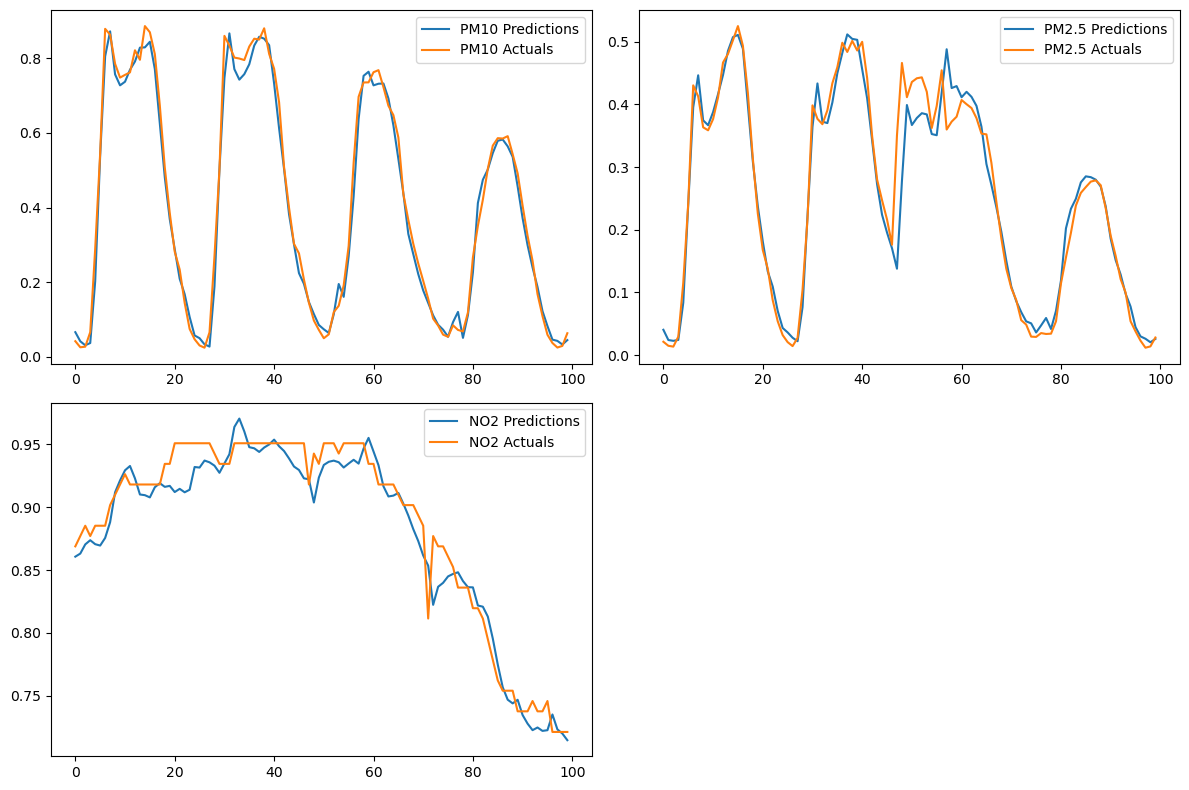

In [169]:
plot_predictions2(model6, X5_test, y5_test)

### Invert Prediction Values
Not working for multitarget predictions

In [ ]:
# Reshape 'Predictions' and 'Actuals' to have one feature
predictions = df['Predictions'].values.reshape(-1, 1)
actuals = df['Actuals'].values.reshape(-1, 1)


In [73]:
predictions_inverted = scaler_y.inverse_transform(predictions)
actuals_inverted = scaler_y.inverse_transform(actuals)

In [75]:
df_inverted = pd.DataFrame({
    'Predictions': predictions_inverted.flatten(),
    'Actuals': actuals_inverted.flatten()
})
df_inverted

,Predictions,Actuals
0,17.151331,11.6
1,16.885956,11.0
2,15.532189,6.2
3,13.222870,7.8
4,13.280419,6.9
5,11.861265,8.1
6,12.661733,8.6
7,13.150102,8.4
8,12.224852,6.6
9,11.035548,8.0


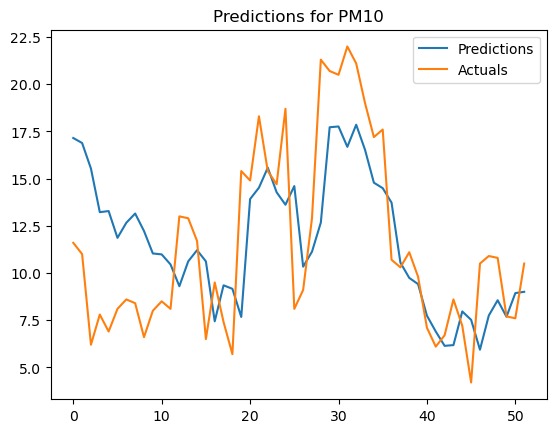

In [83]:
plt.plot(df_inverted['Predictions'])
plt.plot(df_inverted['Actuals'])
plt.title('Predictions for PM10')
plt.legend(['Predictions', 'Actuals'])
plt.savefig('predicts.png')


In [80]:
df_inverted.describe()

,Predictions,Actuals
count,52.000000,52.000000
mean,11.615685,11.407692
std,3.424712,4.813903
min,5.937706,4.200000
25%,8.986202,7.775000
50%,11.081864,10.400000
75%,14.330673,14.750000
max,17.854692,22.000000


# NO2 Predictions

In [17]:

traffic = pd.read_csv('traffic.csv')
traffic_gr= traffic.groupby(['roundedTimestamp', 'Bezeichnung']).sum()
traffic_gr = traffic_gr.reset_index()
traffic_gr
sum_vehicles_list = []

for i, row in traffic_gr.iterrows():
    sum_vehicles = row[2:67].sum()
    sum_vehicles_list.append(sum_vehicles)

traffic_gr['SumVehicles'] = sum_vehicles_list
data = {'intersection' : traffic_gr['Bezeichnung'], 'timestamp' : traffic_gr['roundedTimestamp'], 'sum_vehicles': sum_vehicles_list}
traffic_sum = pd.DataFrame(data = data)
traffic_sum
traffic_sum_total = traffic_sum.groupby('timestamp')['sum_vehicles'].sum()
traffic_sum_total = pd.DataFrame(traffic_sum_total).reset_index()
traffic_sum_total
pred_data1 = traffic_sum_total.merge(weather, how='left', left_on= 'timestamp', right_on='datetime').merge(emissions[['PM10', 'PM2,5', 'NO2', 'datetime']], how='left', left_on= 'timestamp', right_on='datetime' )
pred_data1.drop(columns=['datetime_y', 'datetime_x'], inplace = True)
show(pred_data1)

df_sum = pred_data1.copy()
df_sum.index = pd.to_datetime(df_sum['timestamp'], format='%Y-%m-%d %H:%M:%S')
df_sum[:26]
df_sum['Seconds'] = df_sum.index.map(pd.Timestamp.timestamp)
df_sum
day = 60*60*24
year = 365.2425*day

df_sum['Day sin'] = np.sin(df_sum['Seconds'] * (2* np.pi / day))
df_sum['Day cos'] = np.cos(df_sum['Seconds'] * (2 * np.pi / day))
df_sum['Year sin'] = np.sin(df_sum['Seconds'] * (2 * np.pi / year))
df_sum['Year cos'] = np.cos(df_sum['Seconds'] * (2 * np.pi / year))
df_sum.head()

#drop unwanted columns
df_sum = df_sum.drop(columns = ['timestamp', 'Seconds'])
df_sum = df_sum.fillna(df_sum.mean())
df_sum


scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Separate your DataFrame into features and target variable
X = df_sum.drop(columns=["NO2"])

y = df_sum[["NO2"]]

# Scale the features (X) and target (y) separately
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create a new DataFrame with the scaled features and target variable
df_scaled = pd.DataFrame(data=X_scaled, columns=X.columns, index=df_sum.index)
df_scaled['NO2'] = y
print(df_scaled)

# #move target to be first column
column_to_move = df_scaled.pop('PM10')
df_scaled.insert(0, 'PM10', column_to_move)
df_scaled

def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    #define y
    label = [df_as_np[i+window_size]]
    y.append(label)
  return np.array(X), np.array(y)
X5, y5 = df_to_X_y2(df_scaled)
X5.shape, y5.shape

#split data
X5_train, y5_train = X5[:300], y5[:300]
X5_val, y5_val = X5[300:350], y5[300:350]
X5_test, y5_test = X5[350:], y5[350:]
X5_train.shape, y5_train.shape, X5_val.shape, y5_val.shape, X5_test.shape, y5_test.shape

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.backend import clear_session

# Clear the Keras session
clear_session()

# Set up checkpoint to save the best model
cp5 = ModelCheckpoint('model_no2/', save_best_only=True)

# Create the model
model_no2 = Sequential()

# Input layer
model_no2.add(InputLayer((6,13)))

model_no2.add(LSTM(64))
model_no2.add(Dropout(0.2))

# Decrease the number of neurons in Dense layers and add L1-Regularization
model_no2.add(Dense(64, activation='relu'))#, kernel_regularizer=l1(0.001)))
model_no2.add(Dense(16, activation='relu'))#, kernel_regularizer=l1(0.001)))


model_no2.add(Dense(1, activation='linear'))

#model5.compile(loss='mean_absolute_error', optimizer=Adagrad(learning_rate=1), metrics=[RootMeanSquaredError()])
model_no2.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_squared_error'])

# Display model summary
model_no2.summary()

#fit model
model_no2.fit(X5_train, y5_train, validation_data=(X5_val, y5_val), epochs=20, callbacks=[cp5])
from tensorflow.keras.models import load_model
model_no2 = load_model('model_no2/')
# prdiction for one target value


from sklearn.metrics import mean_squared_error as mse

def plot_predictions_no2(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y_scaled})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)


model_no2.evaluate(X5_test, y5_test)
plot_predictions_no2(model_no2, X5_test, y5_test)

### Invert Prediction Values
# Reshape 'Predictions' and 'Actuals' to have one feature
predictions = df['Predictions'].values.reshape(-1, 1)
actuals = df['Actuals'].values.reshape(-1, 1)

predictions_inverted = scaler_y.inverse_transform(predictions)
actuals_inverted = scaler_y.inverse_transform(actuals)
df_inverted = pd.DataFrame({
    'Predictions': predictions_inverted.flatten(),
    'Actuals': actuals_inverted.flatten()
})
df_inverted
plt.plot(df_inverted['Predictions'])
plt.plot(df_inverted['Actuals'])
plt.title('Predictions for NO2')
plt.legend(['Predictions', 'Actuals'])
plt.savefig('predicts.png')

df_inverted.describe()

                     sum_vehicles  Luftdruck[hPa]  \
timestamp                                           
2022-08-26 07:00:00      0.152252        0.519231   
2022-08-26 07:30:00      0.416343        0.519231   
2022-08-26 08:00:00      0.246817        0.519231   
2022-08-29 07:00:00      0.180765        0.653846   
2022-08-29 07:30:00      0.439424        0.653846   
...                           ...             ...   
2023-09-02 04:00:00      0.449915        0.596154   
2023-09-02 04:30:00      0.081717        0.615385   
2023-09-14 23:00:00      0.100313        0.653846   
2023-09-14 23:30:00      0.248771        0.653846   
2023-09-15 00:00:00      0.083297        0.538462   

                     Relative Luftfeuchtigkeit[%]  Temperatur[°C]  \
timestamp                                                           
2022-08-26 07:00:00                      0.703540        0.859589   
2022-08-26 07:30:00                      0.690265        0.866438   
2022-08-26 08:00:00               

10/10 [==============================] - 19s 2s/step - loss: 2.1977 - mean_squared_error: 61.4838 - val_loss: 1.2620 - val_mean_squared_error: 14.0242
Epoch 2/20
 6/10 [=================>............] - ETA: 0s - loss: 2.1278 - mean_squared_error: 58.5901

10/10 [==============================] - 13s 1s/step - loss: 2.1483 - mean_squared_error: 60.7950 - val_loss: 1.2542 - val_mean_squared_error: 14.3387
Epoch 3/20
 1/10 [==>...........................] - ETA: 0s - loss: 2.3103 - mean_squared_error: 71.9694

10/10 [==============================] - 13s 1s/step - loss: 2.1431 - mean_squared_error: 60.3107 - val_loss: 1.2519 - val_mean_squared_error: 14.2057
Epoch 4/20
 1/10 [==>...........................] - ETA: 0s - loss: 2.0603 - mean_squared_error: 50.5106

KeyboardInterrupt: 

In [18]:
model_no2.evaluate(X5_test, y5_test)

2/2 [==============================] - 0s 13ms/step - loss: 1.2213 - mean_squared_error: 15.2011


[1.2213366031646729, 15.201141357421875]

In [20]:
y_scaled

array([[0.40705563],
       [0.54545455],
       [0.49389417],
       [0.1614654 ],
       [0.20895522],
       [0.16824966],
       [0.38941655],
       [0.37177748],
       [0.40434193],
       [0.16960651],
       [0.18453189],
       [0.17232022],
       [0.44776119],
       [0.37042062],
       [0.40976934],
       [0.10719132],
       [0.12347354],
       [0.13432836],
       [0.1614654 ],
       [0.16824966],
       [0.55088195],
       [0.59972863],
       [0.53052917],
       [0.31886024],
       [0.27815468],
       [0.30664858],
       [0.26322931],
       [0.19131615],
       [0.28765265],
       [0.39755767],
       [0.3256445 ],
       [0.25373134],
       [0.40841248],
       [0.25439477],
       [0.18046133],
       [0.16282225],
       [0.10854817],
       [0.33107191],
       [0.38127544],
       [0.35006784],
       [0.09769335],
       [0.08683853],
       [0.07327001],
       [0.39891452],
       [0.49660787],
       [0.55359566],
       [0.29715061],
       [0.339

In [21]:
  predictions = model_no2.predict(X5_test).flatten()
  predictions


2/2 [==============================] - 1s 4ms/step


array([0.39489594, 0.3919369 , 0.3864199 , 0.38327828, 0.3989609 ,
       0.37143514, 0.38866597, 0.3914678 , 0.39280832, 0.39129168,
       0.38386366, 0.38862395, 0.39220142, 0.363008  , 0.38837725,
       0.3839672 , 0.35231188, 0.36899325, 0.37219903, 0.35975185,
       0.3789525 , 0.3791597 , 0.38967845, 0.39019668, 0.38562325,
       0.39565033, 0.37237075, 0.36640492, 0.38109997, 0.38829815,
       0.38191646, 0.35862264, 0.3744055 , 0.39254963, 0.37432113,
       0.3974858 , 0.3930549 , 0.35477805, 0.38604325, 0.3877738 ,
       0.37906808, 0.3760831 , 0.3800157 , 0.37442803, 0.39482772,
       0.37888357, 0.39273268, 0.3826909 , 0.3839373 , 0.39622152,
       0.40049493, 0.3977729 ], dtype=float32)

In [24]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions_no2(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y_scaled})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)


In [25]:
model_no2.evaluate(X5_test, y5_test)
plot_predictions_no2(model_no2, X5_test, y5_test)

2/2 [==============================] - 0s 9ms/step


ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
### Invert Prediction Values
# Reshape 'Predictions' and 'Actuals' to have one feature
predictions = df['Predictions'].values.reshape(-1, 1)
actuals = df['Actuals'].values.reshape(-1, 1)

predictions_inverted = scaler_y.inverse_transform(predictions)
actuals_inverted = scaler_y.inverse_transform(actuals)
df_inverted = pd.DataFrame({
    'Predictions': predictions_inverted.flatten(),
    'Actuals': actuals_inverted.flatten()
})
df_inverted
plt.plot(df_inverted['Predictions'])
plt.plot(df_inverted['Actuals'])
plt.title('Predictions for NO2')
plt.legend(['Predictions', 'Actuals'])
plt.savefig('predicts.png')

df_inverted.describe()